### Libraries

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = '/content/drive/MyDrive/Bangkit/Capstone/indonesia_tourism_data/'

In [ ]:
!ls /content/drive/MyDrive/Bangkit/Capstone

indonesia_tourism_data


In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

### Loading Data

In [71]:
data_tourism_rating = pd.read_csv(BASE_DIR+'tourism_rating.csv')
data_tourism_with_id = pd.read_csv(BASE_DIR+'tourism_with_id.csv')
data_user = pd.read_csv(BASE_DIR+'user.csv')

In [72]:
data_tourism_rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [73]:
data_tourism_with_id.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [74]:
data_user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


### Data Preparation

In [75]:
data_tourism_rating.isna().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0


In [76]:
data_tourism_with_id.isna().sum()

,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


In [77]:
data_user.isna().sum()

,0
User_Id,0
Location,0
Age,0


In [78]:
print(f'Jumlah data_tourism_rating yang duplikat: {data_tourism_rating.duplicated().sum()}')
print(f'Jumlah data_tourism_with_id yang duplikat: {data_tourism_with_id.duplicated().sum()}')
print(f'Jumlah data_user yang duplikat: {data_user.duplicated().sum()}')

Jumlah data_tourism_rating yang duplikat: 79
Jumlah data_tourism_with_id yang duplikat: 0
Jumlah data_user yang duplikat: 0


In [79]:
data_tourism_rating.drop_duplicates(inplace = True)

In [80]:
data_tourism_with_id.drop(['Rating','Time_Minutes','Coordinate','Lat','Long','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)
data_tourism_with_id

,Place_Id,Place_Name,Description,Category,City,Price
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


In [81]:
data_rekomendasi = pd.merge(data_tourism_rating.groupby('Place_Id')['Place_Ratings'].mean(),data_tourism_with_id,on='Place_Id')
data_rekomendasi

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price
0,1,3.722222,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000
1,2,2.840000,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0
2,3,2.526316,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000
3,4,2.857143,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000
4,5,3.520000,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000
...,...,...,...,...,...,...,...
432,433,3.304348,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000
433,434,2.400000,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0
434,435,3.000000,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0
435,436,3.090909,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0


### Modeling

#### Content Based Filtering

In [ ]:
tv = TfidfVectorizer(max_features=5000)
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()
def preprocessing(data):
    data = data.lower()
    data = stem.stem(data)
    data = stopword.remove(data)
    return data

In [ ]:
data_content_based_filtering = data_rekomendasi.copy()
data_content_based_filtering['Tags'] = data_content_based_filtering['Description'] + ' ' + data_content_based_filtering['Category']
data_content_based_filtering.drop(['Price','Place_Ratings','Description','Category','City'],axis=1,inplace=True)
data_content_based_filtering

,Place_Id,Place_Name,Tags
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu..."
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...
...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...


In [ ]:
data_content_based_filtering['Tags'] = data_content_based_filtering['Tags'].apply(preprocessing)
data_content_based_filtering

In [ ]:
vectors = tv.fit_transform(data_content_based_filtering['Tags']).toarray()
vectors

In [ ]:
similarity = cosine_similarity(vectors)
similarity[0][1:10]

In [108]:
def recommend_by_content_based_filtering(location_name):
    location_name_index = data_content_based_filtering[data_content_based_filtering['Place_Name']==location_name].index[0]
    distancess = similarity[location_name_index]
    location_name_list = sorted(list(enumerate(distancess)),key=lambda x: x[1],reverse=True)[1:100]

    recommended_location_names = []
    for i in location_name_list:
        recommended_location_names.append(data_content_based_filtering.iloc[i[0]]['Place_Name'])


    return recommended_location_names

In [109]:
recommend_by_content_based_filtering('Candi Borobudur')

['Candi Sewu',
 'Candi Prambanan',
 'Patung Buddha Empat Rupa',
 'Candi Gedong Songo',
 'Candi Ijo',
 'Candi Donotirto',
 'Candi Ratu Boko',
 'Kenjeran Park',
 'Pura Giri Natha',
 'Waduk Jatibarang',
 'Gua Maria Kerep Ambarawa',
 'Gedung Sate',
 'Kota Lama Semarang',
 'Masjid Istiqlal',
 'Museum Bank Indonesia',
 'Museum Pendidikan Nasional',
 'Museum Fatahillah',
 'Museum Perangko',
 'Taman Bunga Celosia',
 'Monumen Sanapati',
 'Tebing Breksi',
 'Taman Srigunting',
 'Monumen Bandung Lautan Api',
 'Kidzania',
 'Saloka Theme Park',
 'Sam Poo Kong Temple',
 'Atlantis Land Surabaya',
 'Tugu Muda Semarang',
 'Lava Bantal',
 'Museum Sri Baduga',
 'Jalan Braga',
 'Monumen Selamat Datang',
 'Monumen Yogya Kembali',
 'Galeri Nasional Indonesia',
 'Gua Pawon',
 'Pantai Wediombo',
 'Monumen Palagan Ambarawa',
 'Museum Ullen Sentalu',
 'Balai Kota Surabaya',
 'Wisata Kraton Jogja',
 'Taman Lalu Lintas Ade Irma Suryani Nasution',
 'Keraton Yogyakarta',
 'Masjid Pusdai',
 'Lawang Sewu',
 'Kawasan W

#### Collaborative Filtering

In [82]:
data_collaborative_filtering = data_tourism_rating.copy()
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [83]:
user_ids = data_collaborative_filtering['User_Id'].unique().tolist()
print('userID: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID:', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID:', user_encoded_to_user)

userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

In [84]:
place_ids = data_collaborative_filtering['Place_Id'].unique().tolist()
print('placeID:', place_ids)

place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
print('encoded placeID:', place_to_place_encoded)

place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}
print('encoded angka ke placeID:', place_encoded_to_place)

placeID: [179, 344, 5, 373, 101, 312, 258, 20, 154, 393, 103, 208, 89, 405, 41, 336, 67, 292, 222, 76, 428, 15, 246, 265, 21, 328, 307, 302, 48, 147, 2, 322, 23, 85, 371, 78, 111, 107, 185, 413, 389, 437, 105, 176, 407, 281, 167, 384, 426, 390, 367, 166, 18, 321, 262, 223, 17, 319, 310, 421, 202, 283, 250, 118, 54, 70, 33, 227, 86, 249, 131, 382, 193, 104, 24, 128, 134, 228, 237, 100, 198, 50, 376, 268, 242, 82, 348, 409, 88, 4, 377, 43, 91, 44, 14, 406, 383, 229, 290, 294, 309, 74, 97, 138, 436, 395, 300, 68, 55, 434, 9, 151, 61, 159, 397, 391, 301, 143, 27, 190, 346, 381, 368, 433, 420, 335, 115, 334, 219, 178, 266, 92, 64, 102, 257, 243, 116, 359, 121, 385, 398, 119, 298, 410, 224, 379, 255, 269, 213, 126, 192, 183, 129, 303, 296, 99, 148, 13, 247, 31, 77, 158, 306, 98, 235, 45, 173, 275, 25, 130, 164, 267, 56, 30, 238, 402, 196, 417, 304, 206, 211, 28, 264, 403, 253, 331, 188, 416, 378, 233, 95, 204, 225, 341, 145, 36, 168, 12, 280, 236, 42, 90, 75, 63, 205, 234, 284, 230, 197, 339

In [85]:
data_collaborative_filtering['user'] = data_collaborative_filtering['User_Id'].map(user_to_user_encoded)

data_collaborative_filtering['place'] = data_collaborative_filtering['Place_Id'].map(place_to_place_encoded)

In [86]:
num_users = len(user_to_user_encoded)
print("Total users:",num_users)

num_place = len(place_encoded_to_place)
print("Total places:",num_place)

data_collaborative_filtering['Place_Ratings'] = data_collaborative_filtering['Place_Ratings'].values.astype(np.float32)

min_rating = min(data_collaborative_filtering['Place_Ratings'])

max_rating = max(data_collaborative_filtering['Place_Ratings'])

print('Min Rating: {}, Max Rating: {}'.format(
    min_rating, max_rating
))

Total users: 300
Total places: 437
Min Rating: 1.0, Max Rating: 5.0


In [87]:
data_collaborative_filtering = data_collaborative_filtering.sample(frac=1, random_state=42)
data_collaborative_filtering

,User_Id,Place_Id,Place_Ratings,user,place
5315,161,260,2.0,160,259
518,17,262,2.0,16,54
4362,133,191,5.0,132,240
8447,255,156,1.0,254,241
9105,274,78,3.0,273,35
...,...,...,...,...,...
5782,174,296,3.0,173,154
5237,159,69,4.0,158,406
5437,164,24,5.0,163,74
871,28,131,5.0,27,70


In [88]:
def minmaxscale(x):
  return (x - min_rating) / (max_rating - min_rating)

In [89]:
x = data_collaborative_filtering[['user', 'place']].values

y = data_collaborative_filtering['Place_Ratings'].apply(minmaxscale).values

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2024)

print(x, y)

[[160 259]
 [ 16  54]
 [132 240]
 ...
 [163  74]
 [ 27  70]
 [220  63]] [0.25 0.25 1.   ... 1.   1.   0.5 ]


In [90]:
class TouristRecommender(tf.keras.Model):

  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(TouristRecommender, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.place_embedding = layers.Embedding( # layer embeddings place
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) # layer embedding place bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # call layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # call layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # call layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # call layer embedding 4

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [91]:
model = TouristRecommender(num_users, num_place, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [92]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6941 - root_mean_squared_error: 0.3465 - val_loss: 0.6951 - val_root_mean_squared_error: 0.3466
Epoch 2/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6857 - root_mean_squared_error: 0.3399 - val_loss: 0.6964 - val_root_mean_squared_error: 0.3475
Epoch 3/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6800 - root_mean_squared_error: 0.3377 - val_loss: 0.6988 - val_root_mean_squared_error: 0.3492
Epoch 4/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6768 - root_mean_squared_error: 0.3332 - val_loss: 0.7014 - val_root_mean_squared_error: 0.3510
Epoch 5/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6724 - root_mean_squared_error: 0.3313 - val_loss: 0.7030 - val_root_mean_squared_error: 0.3521
Epoch 6/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6675 - root_mean_squared_error: 0.3266 - val_loss: 0.7047 - val_root_mean_squared_error: 0.3532
Epoch 7/100
992/992 ━━━━━━━━━━━━━━━━━━━━ 2s 2m

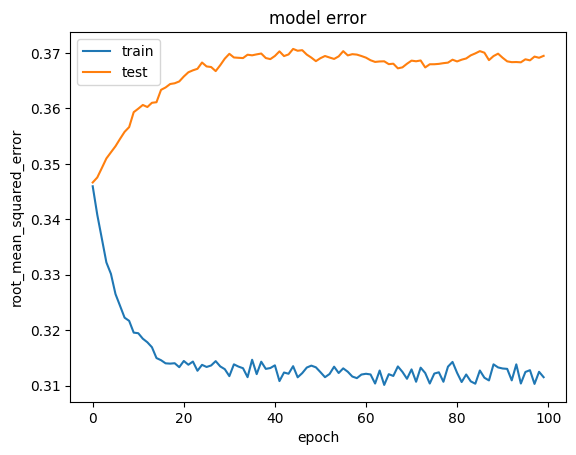

In [93]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

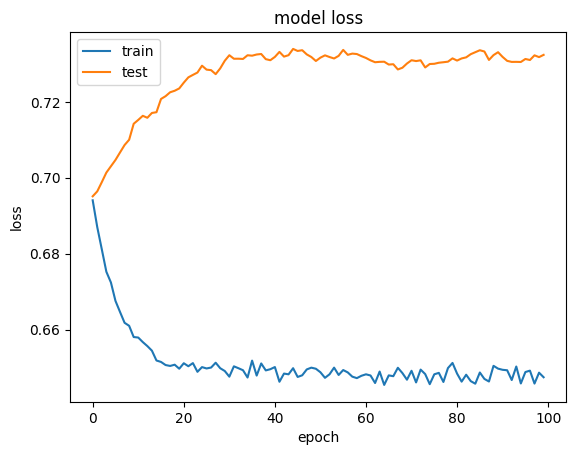

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [95]:
place_df = data_tourism_with_id
df = data_tourism_rating

user_id = df['User_Id'].sample(1).iloc[0]
place_visited_by_user = df[df['User_Id'] == user_id]

In [96]:
place_not_visited = place_df[~place_df['Place_Id'].isin(place_visited_by_user['Place_Id'].values)]['Place_Id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [97]:
ratings = model.predict(user_place_array).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [107]:
top_ratings_indices = ratings.argsort()[-100:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

### Result

In [111]:
search_query = "Sea World"
query_recommendations = recommend_by_content_based_filtering(search_query)

In [112]:
query_recommendations

['Jakarta Aquarium dan Safari',
 'Taman Impian Jaya Ancol',
 'Dunia Fantasi',
 'Museum Tengah Kebun',
 'Museum Fatahillah',
 'Museum Bank Indonesia',
 'Kampung Wisata Taman Sari',
 'Taman Hutan Tebet',
 'Museum Gedung Sate',
 'Taman Miniatur Kereta Api',
 'Taman Sejarah Bandung',
 'Museum Tekstil',
 'Taman Ayodya',
 'Taman Mini Indonesia Indah (TMII)',
 'The World Landmarks - Merapi Park Yogyakarta',
 'Taman Mundu',
 'Perpustakaan Nasional',
 'Museum Macan (Modern and Contemporary Art in Nusantara)',
 'Masjid Salman ITB',
 'Museum Gunung Merapi',
 'Pelabuhan Marina',
 'Museum Taman Prasasti',
 'Museum Sonobudoyo Unit I',
 'Plaza Indonesia',
 'Taman Ekspresi Dan Perpustakaan',
 'Upside Down World Bandung',
 'Museum Kebangkitan Nasional',
 'Museum Nasional',
 'Taman Bungkul',
 'Kampung Batu Malakasari',
 'Taman Spathodea',
 'Museum Kereta Ambarawa',
 'Museum Satria Mandala',
 'Atlantis Land Surabaya',
 'Galeri Indonesia Kaya',
 'Museum Perangko',
 'Museum Sri Baduga',
 'Monumen Yogya Kem

In [113]:
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Place with high ratings from user')
print('----' * 8)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    ['Place_Id'].values
)

place_df_rows = place_df[place_df['Place_Id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.Place_Name)

print('----' * 8)
print('Top 20 place recommendation')
print('----' * 8)

recommended_place = place_df[
    (place_df['Place_Id'].isin(recommended_place_ids)) &
    (place_df['Place_Name'].isin(query_recommendations))
]
for row in recommended_place.itertuples():
    print(row.Place_Name)

Showing recommendations for users: 188
Place with high ratings from user
--------------------------------
Museum Sonobudoyo Unit I
Bukit Moko
Taman Film
Taman Bunga Celosia
Air Mancur Menari
--------------------------------
Top 20 place recommendation
--------------------------------
Atlantis Water Adventure
Taman Impian Jaya Ancol
Kebun Binatang Ragunan
Museum Fatahillah
Museum Bank Indonesia
Museum Taman Prasasti
Taman Menteng
Setu Babakan
Kampung Cina
Museum Tekstil
Alive Museum Ancol
Kampung Wisata Taman Sari
Monumen Yogya Kembali
Pantai Baron
Museum Gunung Merapi
Trans Studio Bandung
Dago Dreampark
Taman Balai Kota Bandung
Kampung Batu Malakasari
Upside Down World Bandung
Pesona Nirwana Waterpark & Cottages
Teras Cikapundung BBWS
Museum Barli
Curug Batu Templek
Gereja Katedral Santo Petrus Bandung
Taman Miniatur Kereta Api
Rainbow Garden
Candi Gedong Songo
Grand Maerakaca
Taman Ekspresi Dan Perpustakaan
Monumen Tugu Pahlawan
Surabaya Museum (Gedung Siola)
Monumen Jalesveva Jayamah

In [100]:
model.save("collaborative_model.h5")